# Predição do clima

A partir da base [WEATHER PREDICTION](https://www.kaggle.com/datasets/ananthr1/weather-prediction),
disponivel no Kaggle iremos criar um modelo capaz de prever o clima apartir da entrada de algums dados

### Importando as bibliotecas necessárias

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mso
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

### Analizando os dados da base

In [46]:
# Importando a base de dados

df = pd.read_csv('seattle-weather.csv')

# Visualizando as 5 primeiras linhas

df.head(5)

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [47]:
# Visualizando o tamanho da base

df.shape

(1461, 6)

/tmp/ipykernel_61844/943819024.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["weather"], palette="hls")


<Axes: xlabel='weather', ylabel='count'>

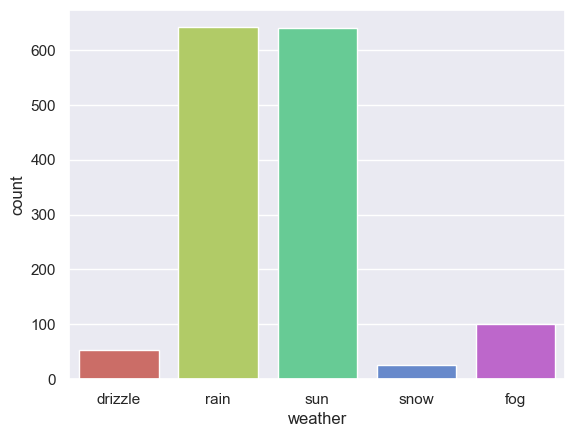

In [48]:
# Visualizando como estão distribuídos os dados

sns.countplot(x=df["weather"], palette="hls")

In [49]:
# Calculando como os atributos estão distribuidos

countrain=len(df[df.weather=="rain"])
countsun=len(df[df.weather=="sun"])
countdrizzle=len(df[df.weather=="drizzle"])
countsnow=len(df[df.weather=="snow"])
countfog=len(df[df.weather=="fog"])

print("Porcentagem de Rain: {:2f}%".format((countrain/(len(df.weather))*100)))
print("Porcentagem de Sun: {:2f}%".format((countsun/(len(df.weather))*100)))
print("Porcentagem de Drizzle: {:2f}%".format((countdrizzle/(len(df.weather))*100)))
print("Porcentagem de Snow: {:2f}%".format((countsnow/(len(df.weather))*100)))
print("Porcentagem de Fog: {:2f}%".format((countfog/(len(df.weather))*100)))

Porcentagem de Rain: 43.874059%
Porcentagem de Sun: 43.805613%
Porcentagem de Drizzle: 3.627652%
Porcentagem de Snow: 1.779603%
Porcentagem de Fog: 6.913073%


### Explorando qual é o tipo dos dados

In [50]:
# Visualizando as estatísticas dos atributos

df[["precipitation","temp_max","temp_min","wind"]].describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


<Axes: xlabel='wind', ylabel='Count'>

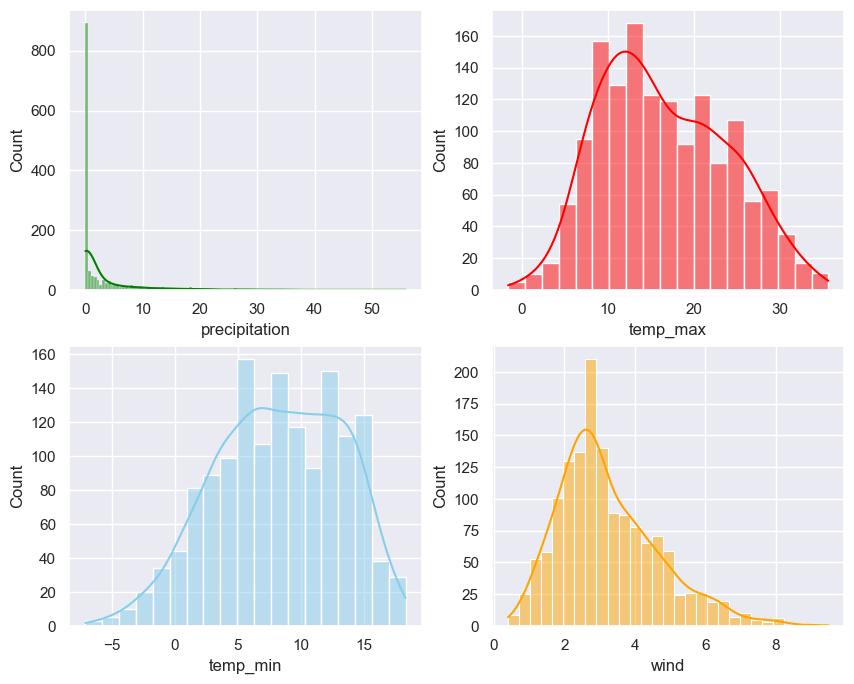

In [51]:
# Visualizando como estão distribuídos os dados de cada atributo

sns.set(style="darkgrid")
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.histplot(data=df,x="precipitation",kde=True,ax=axs[0,0],color='green')
sns.histplot(data=df,x="temp_max",kde=True,ax=axs[0,1],color='red')
sns.histplot(data=df,x="temp_min",kde=True,ax=axs[1,0],color='skyblue')
sns.histplot(data=df,x="wind",kde=True,ax=axs[1,1],color='orange')

### Verificando se a base possui dados ausentes

In [52]:
# Visualizando a quantidade de valores ausentes em cada atributo

df.isna().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

<Axes: >

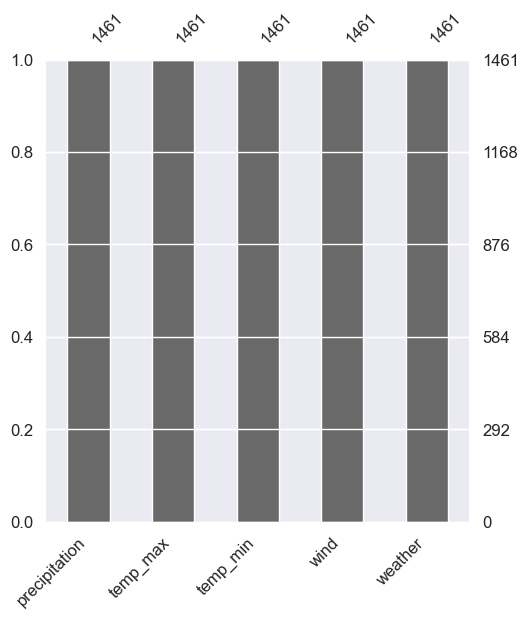

In [53]:
# Visualizando a proporção de valores ausentes em cada atributo

plt.figure(figsize=(12,6))
axz = plt.subplot(1,2,2)
mso.bar(df.drop(["date"],axis=1), ax=axz, fontsize=12)

In [54]:
# Pelo que foi mostrado, não há valores ausentes na base

### Pré-processamento da base

In [55]:
# Removendo os atributos desnecessários

df = df.drop(["date"], axis=1)
df.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.0,12.8,5.0,4.7,drizzle
1,10.9,10.6,2.8,4.5,rain
2,0.8,11.7,7.2,2.3,rain
3,20.3,12.2,5.6,4.7,rain
4,1.3,8.9,2.8,6.1,rain


In [56]:
# Codificando os atributos categóricos

lc=LabelEncoder()
df["weather"]=lc.fit_transform(df["weather"])

df.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.0,12.8,5.0,4.7,0
1,10.9,10.6,2.8,4.5,2
2,0.8,11.7,7.2,2.3,2
3,20.3,12.2,5.6,4.7,2
4,1.3,8.9,2.8,6.1,2


In [57]:
# Separando os atributos de entrada e classificação

x=((df.loc[:,df.columns!="weather"]).astype(int)).values[:,0:]
y=df["weather"].values

df.weather.unique()

array([0, 2, 4, 3, 1])

In [58]:
# # Balancemanto com undersampling
# from imblearn.under_sampling import RandomUnderSampler
# df2 = df.copy()
# rus = RandomUnderSampler(random_state=42)

# x2 = x.copy()
# y2 = y.copy()
# x_res, y_res = rus.fit_resample(x2, y2)

# print(len(x2))
# print(len(y2))
# print(len(x_res))
# print(len(y_res))

# x_res_df = pd.DataFrame(x_res, columns=['prep', 'max', 'min', 'vento'])
# y_res_df = pd.DataFrame(y_res, columns=['weather'])
# df_resampled = pd.concat([x_res_df, y_res_df], axis=1)

# sns.countplot(x=df_resampled["weather"], palette="hls")

In [59]:
# Separando os dados de treino e teste

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

print(x_train.shape)
print(x_test.shape)

(1168, 4)
(293, 4)


In [60]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=42)

# x_res, y_res = ros.fit_resample(x_train, y_train)

# print(len(x_train))
# print(len(y_train))
# print(len(x_res))
# print(len(y_res))

# x_res_df = pd.DataFrame(x_res, columns=['prep', 'max', 'min', 'vento'])
# y_res_df = pd.DataFrame(y_res, columns=['weather'])
# df_resampled = pd.concat([x_res_df, y_res_df], axis=1)

# sns.countplot(x=df_resampled["weather"], palette="hls")

### Encontrando os melhores hiperparametros

In [61]:
# # Definindo os hiperparametros que serão testados para cada modelo

# random_params = {
#     'max_depth': [3,5,10,None],
#     'n_estimators': [10,100,200,300,400,500,600,700,800,900,1000],
#     'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
#     'criterion': ['gini','entropy'],
#     'bootstrap': [True,False],
#     'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
# }

# tree_params = {
#     'max_depth': [None, 2, 4, 6, 8, 10],
#     'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
#     'criterion': ['gini','entropy', 'log_loss'],
#     'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#     'splitter': ['best', 'random'],
#     'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
# }

# NB_params = {
#     'var_smoothing': np.logspace(0, -9, num=100),
# }

# bagging_models_to_test = [
#     DecisionTreeClassifier(),
#     RandomForestClassifier(),
#     GaussianNB(),
# ]

# bagging_params = {
#     'estimator': bagging_models_to_test,
#     'n_estimators': np.arange(10, 200, 10),
#     'max_samples': np.linspace(0.1, 1.0, 10),
#     'max_features': np.linspace(0.1, 1.0, 10),
#     'bootstrap_features': [True,False],
#     'oob_score': [True,False],
#     'n_jobs': [-1],
#     'random_state': list(range(0, 43)),
# }

# XGB_params = {
#     'n_estimators': np.arange(100, 1000, 100),
#     'learning_rate': [0.01, 0.1, 0.2, 0.3],
#     'max_depth': np.arange(3, 10),
#     'min_child_weight': np.arange(1, 6),
#     'subsample': np.linspace(0.6, 1.0, 5),
#     'colsample_bytree': np.linspace(0.6, 1.0, 5),
# }


In [62]:
# # Obtendo os melhores hiperparametros para cada modelo

# tree_model = DecisionTreeClassifier()
# RS_tree = RandomizedSearchCV(tree_model, param_distributions=tree_params, n_iter=20, cv=10, error_score='raise', n_jobs=-1)
# RS_tree.fit(x_train, y_train)
# best_tree = RS_tree.best_estimator_
# print("Best Tree Params: ", RS_tree.best_params_)
# print("Best Tree Score: ", RS_tree.best_score_)

# random_model = RandomForestClassifier()
# RS_random = RandomizedSearchCV(random_model, param_distributions=random_params, n_iter=20, cv=10, error_score='raise', n_jobs=-1)
# RS_random.fit(x_train, y_train)
# best_random = RS_random.best_estimator_
# print("Best Random Params: ", RS_random.best_params_)
# print("Best Random Score: ", RS_random.best_score_)

# NB_model = GaussianNB()
# RS_nb = RandomizedSearchCV(NB_model, param_distributions=NB_params, n_iter=20, cv=10, error_score='raise', n_jobs=-1)
# RS_nb.fit(x_train, y_train)
# best_NB = RS_nb.best_estimator_
# print("Best NB Params: ", RS_nb.best_params_)
# print("Best NB Score: ", RS_nb.best_score_)

# XGB_model = XGBClassifier()
# RS_xgb = RandomizedSearchCV(XGB_model, param_distributions=XGB_params, n_iter=20, cv=10, error_score='raise', n_jobs=-1)
# RS_xgb.fit(x_train, y_train)
# best_XGB = RS_xgb.best_estimator_
# print("Best XGB Params: ", RS_xgb.best_params_)
# print("Best XGB Score: ", RS_xgb.best_score_)

# bagging_model = BaggingClassifier()
# RS_bagging = RandomizedSearchCV(bagging_model, param_distributions=bagging_params, n_iter=20, cv=10, error_score='raise', n_jobs=-1)
# RS_bagging.fit(x_train, y_train)
# best_bagging = RS_bagging.best_estimator_
# print("Best Bagging Params: ", RS_bagging.best_params_)
# print("Best Bagging Score: ", RS_bagging.best_score_)


In [63]:
# Tirei a busca por hiperparametros pra ser rapido, ja usei direto oq foi encontrado em outra busca

tree_model = DecisionTreeClassifier(splitter = 'best', min_samples_split = 3, min_samples_leaf = 1, max_features = None, max_depth = 2, criterion = 'gini')
best_tree = tree_model.fit(x_train, y_train)

random_model = RandomForestClassifier(n_estimators = 900, min_samples_leaf = 7, max_features = 'log2', max_depth = 5, criterion = 'gini', bootstrap = False)
best_random = random_model.fit(x_train, y_train)

NB_model = GaussianNB(var_smoothing = 2.848035868435799e-07)
best_NB = NB_model.fit(x_train, y_train)

XGB_model = XGBClassifier(subsample = 0.9, n_estimators = 800, min_child_weight = 2, max_depth = 3, learning_rate = 0.01, colsample_bytree = 0.8)
best_XGB = XGB_model.fit(x_train, y_train)

bagging_model = BaggingClassifier(
    random_state = 16, oob_score = True, n_jobs = -1, n_estimators = 110, max_samples = 0.1, max_features = 0.6, estimator = DecisionTreeClassifier(), bootstrap_features = False
)
best_bagging = bagging_model.fit(x_train, y_train)


### Testando os modelos

/tmp/ipykernel_61844/3214457224.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=scores, palette="hls")


<Axes: >

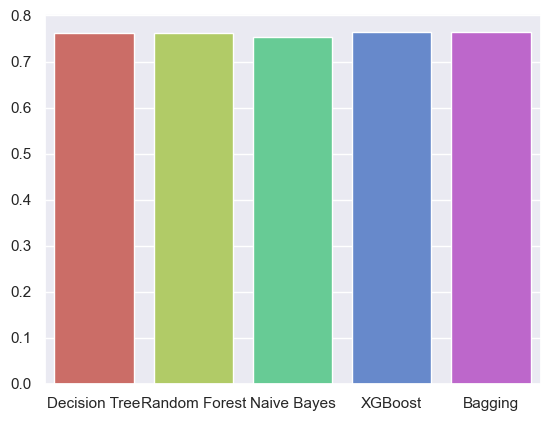

In [64]:
# Acuracia dos modelos

tree_pred = best_tree.predict(x_test)
random_pred = best_random.predict(x_test)
NB_pred = best_NB.predict(x_test)
XGB_pred = best_XGB.predict(x_test)
bagging_pred = best_bagging.predict(x_test)

scores = [accuracy_score(y_test, tree_pred), accuracy_score(y_test, random_pred), accuracy_score(y_test, NB_pred), accuracy_score(y_test, XGB_pred), accuracy_score(y_test, bagging_pred)]
model_names = ['Decision Tree', 'Random Forest', 'Naive Bayes', 'XGBoost', 'Bagging']

sns.barplot(x=model_names, y=scores, palette="hls")

In [65]:
# Classification Report

labels = ['drizzle', 'fog', 'rain', 'snow', 'sun']

print("Decision Tree:")
print(classification_report(y_test,tree_pred, zero_division = 1, target_names=labels))
print("Random Forest:")
print(classification_report(y_test,random_pred, zero_division = 1, target_names=labels))
print("Naive Bayes:")
print(classification_report(y_test,NB_pred, zero_division = 1, target_names=labels))
print("XGBoost:")
print(classification_report(y_test,XGB_pred, zero_division = 1, target_names=labels))
print("Bagging:")
print(classification_report(y_test,bagging_pred, zero_division = 1, target_names=labels))

Decision Tree:
              precision    recall  f1-score   support

     drizzle       1.00      0.00      0.00         9
         fog       1.00      0.00      0.00        25
        rain       0.98      0.73      0.84       120
        snow       0.57      0.50      0.53         8
         sun       0.67      1.00      0.80       131

    accuracy                           0.76       293
   macro avg       0.84      0.45      0.43       293
weighted avg       0.83      0.76      0.72       293

Random Forest:
              precision    recall  f1-score   support

     drizzle       1.00      0.00      0.00         9
         fog       1.00      0.00      0.00        25
        rain       0.95      0.75      0.84       120
        snow       0.50      0.25      0.33         8
         sun       0.68      1.00      0.81       131

    accuracy                           0.76       293
   macro avg       0.82      0.40      0.40       293
weighted avg       0.82      0.76      0.71    

/tmp/ipykernel_61844/409787328.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modelo', y='Precisão', data=df, palette='Blues', ax=axes[0])
/tmp/ipykernel_61844/409787328.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modelo', y='Recall', data=df, palette='Oranges', ax=axes[1])
/tmp/ipykernel_61844/409787328.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modelo', y='F1-score', data=df, palette='Greens', ax=axes[2])


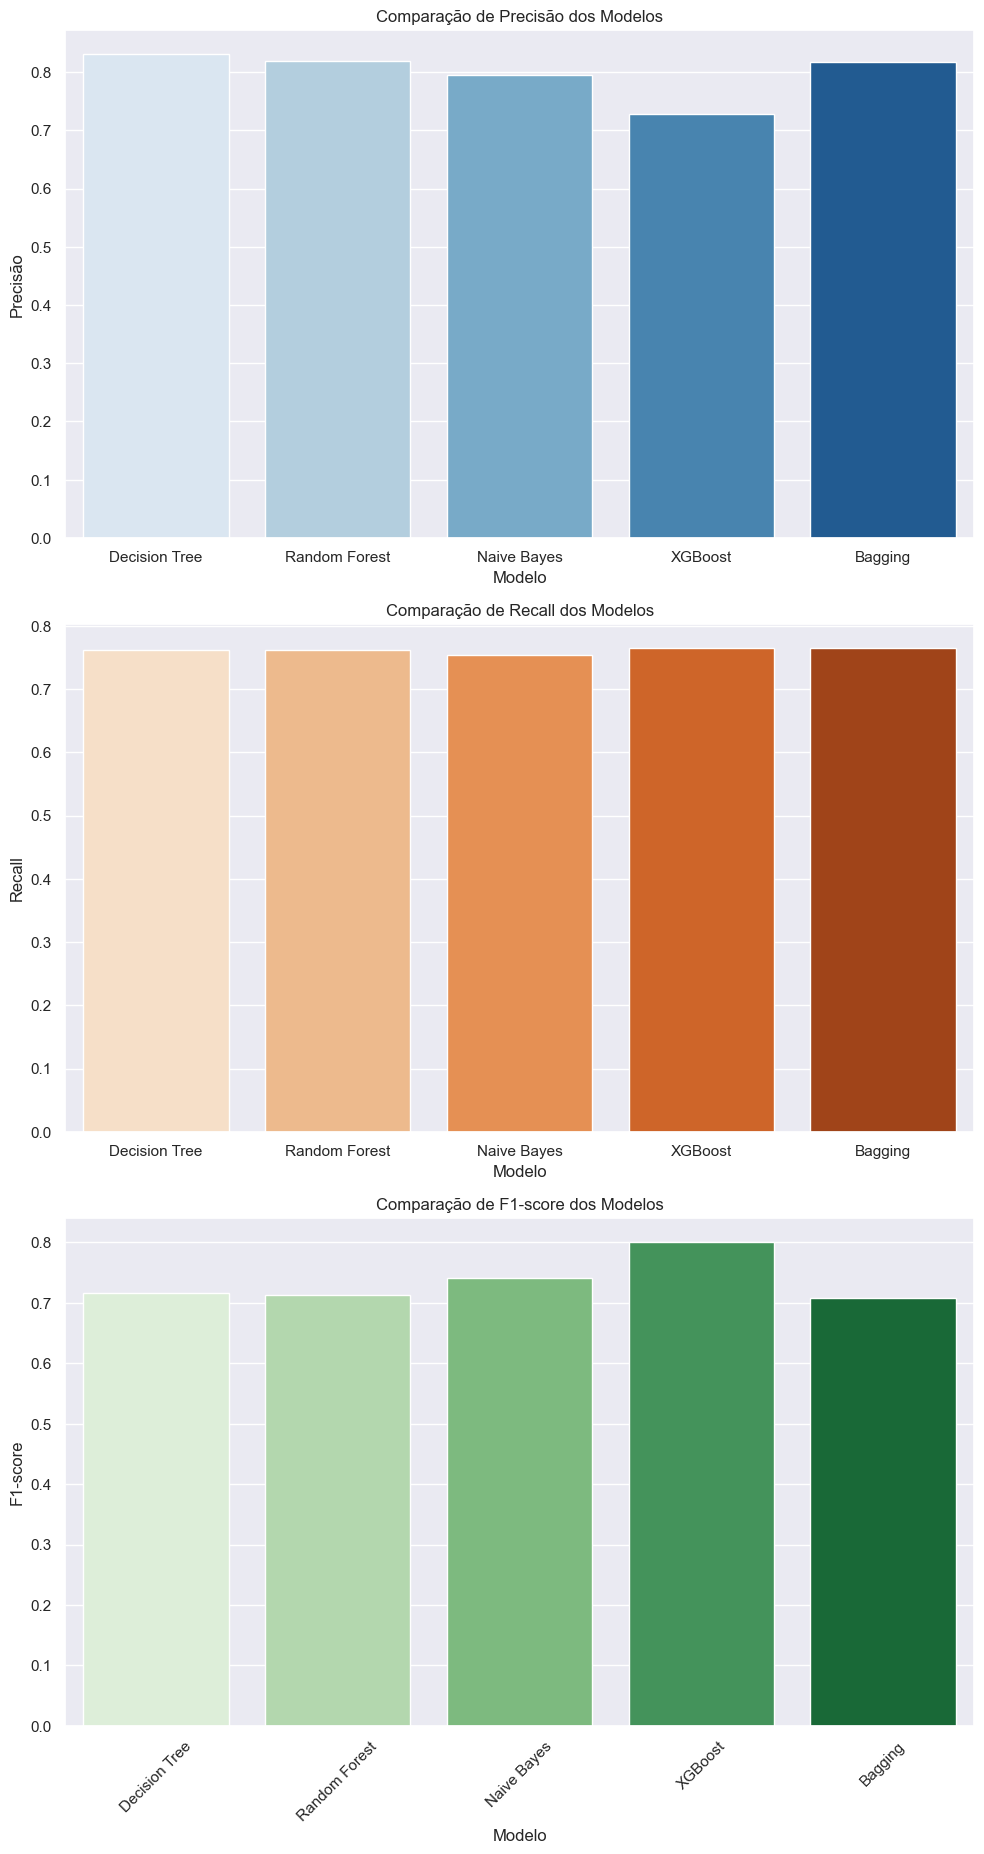

In [66]:
results = {
    'Modelo': ['Decision Tree', 'Random Forest', 'Naive Bayes', 'XGBoost', 'Bagging'],
    'Precisão': [
        classification_report(y_test, tree_pred, output_dict=True, zero_division = 1)['weighted avg']['precision'],
        classification_report(y_test, random_pred, output_dict=True, zero_division = 1)['weighted avg']['precision'],
        classification_report(y_test, NB_pred, output_dict=True, zero_division = 1)['weighted avg']['precision'],
        classification_report(y_test, XGB_pred, output_dict=True, zero_division = 1)['weighted avg']['precision'],
        classification_report(y_test, bagging_pred, output_dict=True, zero_division = 1)['weighted avg']['precision']
    ],
    'Recall': [
        classification_report(y_test, tree_pred, output_dict=True, zero_division = 1)['weighted avg']['recall'],
        classification_report(y_test, random_pred, output_dict=True, zero_division = 1)['weighted avg']['recall'],
        classification_report(y_test, NB_pred, output_dict=True, zero_division = 1)['weighted avg']['recall'],
        classification_report(y_test, XGB_pred, output_dict=True, zero_division = 1)['weighted avg']['recall'],
        classification_report(y_test, bagging_pred, output_dict=True, zero_division = 1)['weighted avg']['recall']
    ],
    'F1-score': [
        classification_report(y_test, tree_pred, output_dict=True, zero_division = 1)['weighted avg']['f1-score'],
        classification_report(y_test, random_pred, output_dict=True, zero_division = 1)['weighted avg']['f1-score'],
        classification_report(y_test, NB_pred, output_dict=True, zero_division = 1)['weighted avg']['f1-score'],
        classification_report(y_test, XGB_pred, output_dict=True, zero_division = 1)['weighted avg']['f1-score'],
        classification_report(y_test, bagging_pred, output_dict=True, zero_division = 1)['weighted avg']['f1-score']
    ]
}

# Criar um DataFrame a partir do dicionário
df = pd.DataFrame(results)

# Criar gráficos separados para cada métrica usando subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Gráfico para Precisão
sns.barplot(x='Modelo', y='Precisão', data=df, palette='Blues', ax=axes[0])
axes[0].set_ylabel('Precisão')
axes[0].set_title('Comparação de Precisão dos Modelos')

# Gráfico para Recall
sns.barplot(x='Modelo', y='Recall', data=df, palette='Oranges', ax=axes[1])
axes[1].set_ylabel('Recall')
axes[1].set_title('Comparação de Recall dos Modelos')

# Gráfico para F1-score
sns.barplot(x='Modelo', y='F1-score', data=df, palette='Greens', ax=axes[2])
axes[2].set_ylabel('F1-score')
axes[2].set_title('Comparação de F1-score dos Modelos')

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()